<a href="https://colab.research.google.com/github/joshuajacobs2020/AirbnbPricePrediction/blob/main/Data_Cleaning_Kaggle_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Cleaning and Dimension Reduction
Here I use clean the Kaggle dataset found here:
https://www.kaggle.com/datasets/dgomonov/new-york-city-airbnb-open-data/data

I also do a dimension reduction of the names variables as I will show below.

In [1]:
!git clone https://github.com/joshuajacobs2020/AirbnbPricePrediction
%cd /content/AirbnbPricePrediction/Data

Cloning into 'AirbnbPricePrediction'...
remote: Enumerating objects: 85, done.
remote: Counting objects: 100% (85/85), done.
remote: Compressing objects: 100% (79/79), done.
remote: Total 85 (delta 20), reused 9 (delta 2), pack-reused 0
Receiving objects: 100% (85/85), 84.57 MiB | 21.89 MiB/s, done.
Resolving deltas: 100% (20/20), done.
/content/AirbnbPricePrediction/Data


## Loading Data

In [2]:
import pandas as pd
import numpy as np
df = pd.read_csv("AB_NYC_2019.csv")
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


## Cleaning Price Data

In [14]:
# Remove NAs
airbnb = df[df["price"].isnull()==False]

## Cleaning Review Data

In [19]:
# Set that if number of reviews is 0, fill missing reviews per month with 0
airbnb.loc[((airbnb["reviews_per_month"].isnull()) & (airbnb["number_of_reviews"]==0)), "reviews_per_month"] = 0

In [134]:
# Converting to datetime variable
airbnb["last_review"] = pd.to_datetime(airbnb["last_review"])

# Making a variable listing days since it was last reviewed - use with caution
time = airbnb["last_review"].max()
dates = (airbnb["last_review"].max() - airbnb["last_review"]).dt.days
airbnb["days_since_last_review"]  = dates.astype(str)
airbnb["days_since_last_review"] # lots of NA values created

0        262.0
1         48.0
2          nan
3          3.0
4        231.0
         ...  
48890      nan
48891      nan
48892      nan
48893      nan
48894      nan
Name: days_since_last_review, Length: 48895, dtype: object

## Recoding variables into Factors

In [15]:
# Getting boroughs dummies

# Fixing misspellings
airbnb.loc[airbnb["neighbourhood_group"]=="brookln", "neighbourhood_group"] = "Brooklyn"
airbnb.loc[airbnb["neighbourhood_group"]=="manhatan", "neighbourhood_group"] = "Manhattan"
airbnb = airbnb[airbnb["neighbourhood_group"].isnull()==False]

# Creating Dummies
boroughs = pd.get_dummies(airbnb["neighbourhood_group"],dtype=int)
airbnb = airbnb.join(boroughs)

# Show number of obs in each borough
print(airbnb.groupby("neighbourhood_group").size())

neighbourhood_group
Bronx             1091
Brooklyn         20104
Manhattan        21661
Queens            5666
Staten Island      373
dtype: int64


In [82]:
# Room types factor variable
roomtypes = pd.get_dummies(airbnb["room_type"],dtype=int)
airbnb = airbnb.join(roomtypes)
airbnb.groupby("room_type").size()

room_type
Entire home/apt    25409
Private room       22326
Shared room         1160
dtype: int64

## Extracting Name Data Using Dimension Reduction

The types of words listed in the `name` variable would likely correspond to the quality of the listing. We can try to extract the most common, meaningful words used and see if they predict prices.

Since this will generate a high-dimensional dataset, we can attempt to reduce the dimensionality of these by applying PCA.

The first step is to get a list of all the words used in each listing and filter them down to the most common meaningful keywords

In [83]:
# Collecting counts of all words used for listings
from collections import Counter
import string

names_counter = Counter()
for words in airbnb["name"]:
  words = str(words).lower()
  words = ''.join([char for char in words if char not in string.punctuation])
  for word in str(words).split(' '):
      names_counter[word] += 1

names = list(names_counter.keys())
counts = list(names_counter.values())

text_counts = {"names": names, "counts": counts}
text_df = pd.DataFrame(text_counts)

In [86]:
freq_lim = 1000 # determines how often words have to be used to be included

# Getting rid of obviously trivial words
bad_names = ["and","AND","by","the",""," ","","UNTITLED","or","For","for","OF", "MY","My","an","of","in","on","a","to","w","at","from"]

# Filtering text to high frequency, non-trivial words
text_filter = text_df.loc[text_df['counts'] > freq_lim,]
text_filter = text_filter[~text_filter["names"].isin(bad_names)]

# Here we can see all the words that are being selected
text_filter

,names,counts
0,clean,1087
2,quiet,1198
3,apt,4616
4,home,1838
7,park,3038
9,midtown,1245
11,village,2253
15,cozy,4989
18,brownstone,1179
19,spacious,3721


In [87]:
# Create filtered names from acceptable names
airbnb_text = airbnb[["id","name","price"]]
airbnb_text["name"] = airbnb_text["name"].str.lower()

def filter_words(text):
    return ' '.join([word for word in str(text).split(' ') if word in list(text_filter["names"])])

# Apply the function to the 'text' column
copy = airbnb_text['name'].copy()
airbnb_text['filtered_text'] = copy.apply(filter_words)

airbnb_text

<ipython-input-87-166a9c80bea0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  airbnb_text["name"] = airbnb_text["name"].str.lower()
<ipython-input-87-166a9c80bea0>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  airbnb_text['filtered_text'] = copy.apply(filter_words)


,id,name,price,filtered_text
0,2539,clean & quiet apt home by the park,149,clean quiet apt home park
1,2595,skylit midtown castle,225,midtown
2,3647,the village of harlem....new york !,150,village
3,3831,cozy entire floor of brownstone,89,cozy brownstone
4,5022,entire apt: spacious studio/loft by central park,80,spacious central park
...,...,...,...,...
48890,36484665,charming one bedroom - newly renovated rowhouse,70,charming one bedroom
48891,36485057,affordable room in bushwick/east williamsburg,40,room williamsburg
48892,36485431,sunny studio at historical neighborhood,115,sunny studio
48893,36485609,43rd st. time square-cozy single bed,55,bed


Now we convert each keyword into a dummy variable which is `1` if the name contains the keyword, and `0` otherwise.

In [88]:
# Create empty rows
for word in text_filter["names"]:
    airbnb_text[word] = 0

# Update the columns with 1 if the word is in the text
for idx, row in airbnb_text.iterrows():
  for word in row['filtered_text'].split(' '):
      airbnb_text.at[idx, word] = 1

airbnb_text = airbnb_text.drop("", axis=1)

airbnb_text.head()

,id,name,price,filtered_text,clean,quiet,apt,home,park,midtown,...,bright,new,great,location,square,heart,one,luxury,close,bushwick
0,2539,clean & quiet apt home by the park,149,clean quiet apt home park,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2595,skylit midtown castle,225,midtown,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,3647,the village of harlem....new york !,150,village,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3831,cozy entire floor of brownstone,89,cozy brownstone,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5022,entire apt: spacious studio/loft by central park,80,spacious central park,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


Now we reduce the dimensionality of all these dummy variables using PCA. Here I take 6 principle components.

In [97]:
# Make array of values and reduce dimensionality with PCR
text_array = np.array(airbnb_text.drop(["id","name","price","filtered_text"],axis=1))

import numpy as np
from sklearn.decomposition import PCA
pca = PCA(n_components=6)
pca.fit(text_array)
reduced = pca.fit_transform(text_array)
reduced_df_pca = pd.DataFrame(data=reduced,columns=["textfeat1","textfeat2","textfeat3","textfeat4","textfeat5","textfeat6"])

We can test how these predict price in a simple OLS model. As we can see, all 6 text features seem to be significant.

In [98]:
# Combining text features and testing model

import statsmodels.api as sm
reducedconst = sm.add_constant(reduced_df_pca)
model = sm.OLS(airbnb["price"],reducedconst, missing="drop")
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     238.9
Date:                Wed, 24 Apr 2024   Prob (F-statistic):          3.77e-302
Time:                        02:47:42   Log-Likelihood:            -3.3668e+05
No. Observations:               48895   AIC:                         6.734e+05
Df Residuals:                   48888   BIC:                         6.734e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        152.7207      1.071    142.656      0.000     150.622     154.819
textfeat1    -76.2024      2.421    -31.475      0.000     -80.948     -71.457
textfeat2    -37.0794      2.853    -12.996      0.000     -42.672     -31.487
textfeat3    -24.4196      3.221     -7.581      0.000     -30.733     -18.106
textfeat4     42.3058      3.495     12.105      0.000      35.456      49.156
textfeat5    -14.2265      3.611     -3.940      0.000     -21.303      -7.150
textfeat6     27.5875      3.739      7.378      0.000      20.258      34.917
==============================================================================
Omnibus:                   106564.711   Durbin-Watson:                   1.838
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        772710371.371
Skew:                          19.749   Prob(JB):                         0.00
Kurtosis:                     617.592   Cond. No.                         3.49
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

What are these text features capturing? We gain some insight by using a correlation matrix

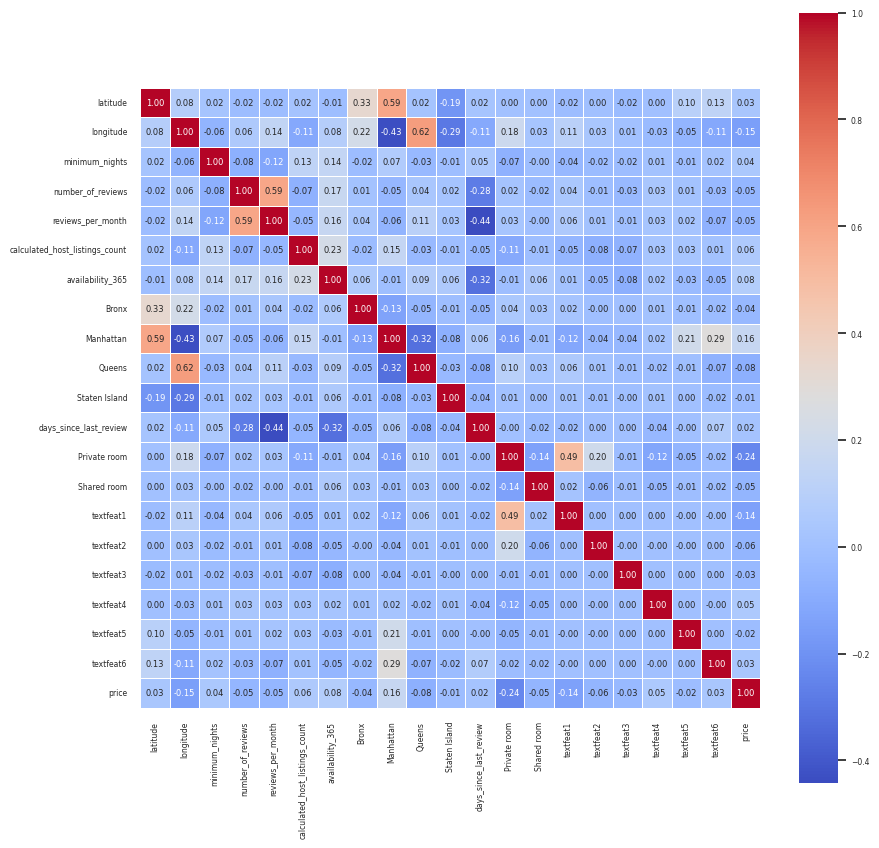

In [110]:
# Merging Data
airbnb_final = airbnb.join(reduced_df_pca)

# Creating correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=.5)

# Create a masked heatmap
plt.figure(figsize = (10,10))
sns.heatmap(airbnb_final[['latitude', 'longitude',
       'minimum_nights', 'number_of_reviews',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'Bronx', 'Manhattan', 'Queens',
       'Staten Island', 'days_since_last_review',
       'Private room', 'Shared room', 'textfeat1', 'textfeat2',
       'textfeat3', 'textfeat4', 'textfeat5', 'textfeat6','price']].corr(),
            cmap = 'coolwarm', annot=True, fmt=".2f", square=True, linewidths=.5)
plt.grid(False)
plt.show()

We can see the first and second text features are positively correlated with `private room` while the 5th and 6th are correlated with Manhattan. Of course, there are likely other unmeasured factors influencing the text features.

## Testing with an OLS regression

Here I put all of the variables in an OLS regression and see what R-squared we can get

In [131]:
Y = airbnb_final["price"]
X = airbnb_final[['latitude', 'longitude',
       'minimum_nights', 'number_of_reviews',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'Bronx', 'Manhattan', 'Queens',
       'Staten Island', 'Private room', 'Shared room', 'textfeat1', 'textfeat2',
       'textfeat3', 'textfeat4', 'textfeat5', 'textfeat6']] # Use Brooklyn as the base, cancellation flexible as base, home/apt as base
X = X.join(pd.get_dummies(airbnb["neighbourhood"],dtype=int))
X = sm.add_constant(X)
X = X.drop('Midtown', axis=1) # Midtown is base

model = sm.OLS(Y,X, missing="drop")
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.121
Model:                            OLS   Adj. R-squared:                  0.117
Method:                 Least Squares   F-statistic:                     28.50
Date:                Wed, 24 Apr 2024   Prob (F-statistic):               0.00
Time:                        03:03:48   Log-Likelihood:            -3.3423e+05
No. Observations:               48895   AIC:                         6.689e+05
Df Residuals:                   48659   BIC:                         6.710e+05
Df Model:                         235                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                          -4.754e+04   1.29e+04     -3.672      0.000   -7.29e+04   -2.22e+04
latitude                         -43.6562    185.403     -0.235      0.814    -407.049     319.737
longitude                       -681.5029    141.554     -4.814      0.000    -958.951    -404.055
minimum_nights                    -0.0939      0.051     -1.823      0.068      -0.195       0.007
number_of_reviews                 -0.2394      0.029     -8.279      0.000      -0.296      -0.183
reviews_per_month                 -2.3150      0.821     -2.819      0.005      -3.925      -0.705
calculated_host_listings_count    -0.2103      0.036     -5.775      0.000      -0.282      -0.139
availability_365                   0.1888      0.009     22.131      0.000       0.172       0.205
Bronx                           -875.7149    262.563     -3.335      0.001   -1390.341    -361.089
Manhattan                       -809.2277    266.462     -3.037      0.002   -1331.497    -286.958
Queens                          -834.5611    238.376     -3.501      0.000   -1301.781    -367.341
Staten Island                  -1028.5101    260.697     -3.945      0.000   -1539.479    -517.541
Private room                     -96.0785      2.571    -37.374      0.000    -101.117     -91.040
Shared room                     -128.4950      6.976    -18.420      0.000    -142.168    -114.822
textfeat1                         -3.4782      2.717     -1.280      0.201      -8.804       1.848
textfeat2                         -3.5409      2.823     -1.254      0.210      -9.074       1.992
textfeat3                        -15.1815      3.105     -4.890      0.000     -21.266      -9.097
textfeat4                         13.0101      3.398      3.829      0.000       6.351      19.670
textfeat5                        -47.1118      3.784    -12.449      0.000     -54.529     -39.694
textfeat6                        -19.1976      4.305     -4.459      0.000     -27.636     -10.759
Allerton                         -11.5382     36.002     -0.320      0.749     -82.103      59.027
Arden Heights                   -133.3818    112.677     -1.184      0.237    -354.229      87.466
Arrochar                         -23.8119     51.823     -0.459      0.646    -125.385      77.761
Arverne                           30.8703     31.581      0.977      0.328     -31.030      92.770
Astoria                          -64.1404     25.285     -2.537      0.011    -113.700     -14.581
Bath Beach                     -1022.9604    258.484     -3.958      0.000   -1529.593    -516.328
Battery Park City                 63.8141     29.331      2.176      0.030       6.325     121.303
Bay Ridge                       -966.9747    258.791     -3.737      0.000   -1474.207    -459.742
Bay Terrace   

## Checking for missing values

Beware using `days_since_last_review` lots missing

In [136]:
# Print number of missing values for each variable
for col in airbnb_final.columns.values:
  miss = airbnb_final[airbnb_final[col].isnull()].shape[0]
  print(col, miss)

id 0
name 16
host_id 0
host_name 21
neighbourhood_group 0
neighbourhood 0
latitude 0
longitude 0
room_type 0
price 0
minimum_nights 0
number_of_reviews 0
last_review 10052
reviews_per_month 0
calculated_host_listings_count 0
availability_365 0
Bronx 0
Brooklyn 0
Manhattan 0
Queens 0
Staten Island 0
days_since_last_review 10052
Entire home/apt 0
Private room 0
Shared room 0
textfeat1 0
textfeat2 0
textfeat3 0
textfeat4 0
textfeat5 0
textfeat6 0


In [105]:
airbnb_final.columns.values

array(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'Bronx', 'Brooklyn', 'Manhattan', 'Queens',
       'Staten Island', 'days_since_last_review', 'Entire home/apt',
       'Private room', 'Shared room', 'textfeat1', 'textfeat2',
       'textfeat3', 'textfeat4', 'textfeat5', 'textfeat6'], dtype=object)

In [137]:
airbnb_final.to_csv("ImprovedAirbnbCleaned.csv")